In [50]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import quandl
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

In [18]:
url_eur= 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=EURUSD&outputsize=full&apikey='+'8YH9QLMWXNG5DNG0'
r_eur = requests.get(url_eur)
eur_usd = r_eur.json()
#eur_usd['Time Series (Daily)']

In [19]:
#app = TimeSeries('8YH9QLMWXNG5DNG0')
#eur_usd = app.get_daily_adjusted('EURUSD', outputsize=full)

In [20]:
'''
date= eur_usd[0].keys()
close = []
for item in date:
    close.append(eur_usd[0][item]['4. close'])
'''

"\ndate= eur_usd[0].keys()\nclose = []\nfor item in date:\n    close.append(eur_usd[0][item]['4. close'])\n"

In [21]:
date= eur_usd['Time Series (Daily)'].keys()
close = []
for item in date:
    close.append(eur_usd['Time Series (Daily)'][item]['4. close'])

In [22]:
eur_usd = pd.DataFrame(close, columns = ['Close'])
eur_usd['Date']= date
eur_usd.set_index(['Date'], inplace=True)
eur_usd.sort_values(by='Date', ascending = True, inplace=True)
eur_usd = eur_usd['2018-09-21':]
eur_usd.reset_index(inplace= True)
eur_usd

,Date,Close
0,2018-09-21,1.17474
1,2018-09-24,1.175
2,2018-09-25,1.17662
3,2018-09-26,1.1749
4,2018-09-27,1.16346
...,...,...
711,2021-06-14,1.21182
712,2021-06-15,1.2128
713,2021-06-16,1.1994
714,2021-06-17,1.1905


In [23]:
signals_df = eur_usd.loc[:, ["Date", "Close"]].copy()

# Set the short window and long windows
short_window = 50
long_window = 100

# Set the `date` column as the index
signals_df = signals_df.set_index("Date", drop=True)

# Generate the short and long moving averages (50 and 100 days, respectively)
signals_df["SMA50"] = signals_df["Close"].rolling(window=short_window).mean()
signals_df["SMA100"] = signals_df["Close"].rolling(window=long_window).mean()
signals_df["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
signals_df["Signal"][short_window:] = np.where(
    signals_df["SMA50"][short_window:] > signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df["Entry/Exit"] = signals_df["Signal"].diff()



<ipython-input-23-787f9612ca1b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["Signal"][short_window:] = np.where(


In [24]:
signals_df.head()

,Close,SMA50,SMA100,Signal,Entry/Exit
Date,,,,,
2018-09-21,1.17474,NaN,NaN,0.0,NaN
2018-09-24,1.175,NaN,NaN,0.0,0.0
2018-09-25,1.17662,NaN,NaN,0.0,0.0
2018-09-26,1.1749,NaN,NaN,0.0,0.0
2018-09-27,1.16346,NaN,NaN,0.0,0.0


In [25]:
signals_df["Close"] = pd.to_numeric(signals_df["Close"], downcast="float")

In [26]:

exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

security_close = signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

moving_avgs = signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Creating Various Trade Signlas

In [27]:
eur_usd.set_index(pd.to_datetime(eur_usd['Date'], infer_datetime_format=True), inplace=True)
eur_usd.drop(columns=['Date'], inplace=True)
eur_usd['Close'] = eur_usd['Close'].astype(float)
eur_signals = eur_usd
eur_signals

,Close
Date,
2018-09-21,1.17474
2018-09-24,1.17500
2018-09-25,1.17662
2018-09-26,1.17490
2018-09-27,1.16346
...,...
2021-06-14,1.21182
2021-06-15,1.21280
2021-06-16,1.19940


In [28]:
eur_signals['Daily Returns'] = eur_signals['Close'].dropna().pct_change()
eur_signals

,Close,Daily Returns
Date,,
2018-09-21,1.17474,NaN
2018-09-24,1.17500,0.000221
2018-09-25,1.17662,0.001379
2018-09-26,1.17490,-0.001462
2018-09-27,1.16346,-0.009737
...,...,...
2021-06-14,1.21182,0.000842
2021-06-15,1.21280,0.000809
2021-06-16,1.19940,-0.011049


In [29]:
# Set short and long windows
short_window_eur = 1
long_window_eur = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eur_signals['fast_close'] = eur_signals['Close'].ewm(halflife=short_window).mean()
eur_signals['slow_close'] = eur_signals['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
eur_signals['crossover_long'] = np.where(eur_signals['fast_close'] > eur_signals['slow_close'], 1.0, 0.0)
eur_signals['crossover_short'] = np.where(eur_signals['fast_close'] < eur_signals['slow_close'], -1.0, 0.0)
eur_signals['crossover_signal'] = eur_signals['crossover_long'] + eur_signals['crossover_short']

eur_signals.head()

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
2018-09-21,1.17474,NaN,1.174740,1.174740,0.0,0.0,0.0
2018-09-24,1.17500,0.000221,1.174871,1.174870,1.0,0.0,1.0
2018-09-25,1.17662,0.001379,1.175462,1.175458,1.0,0.0,1.0
2018-09-26,1.17490,-0.001462,1.175319,1.175317,1.0,0.0,1.0
2018-09-27,1.16346,-0.009737,1.172881,1.172912,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

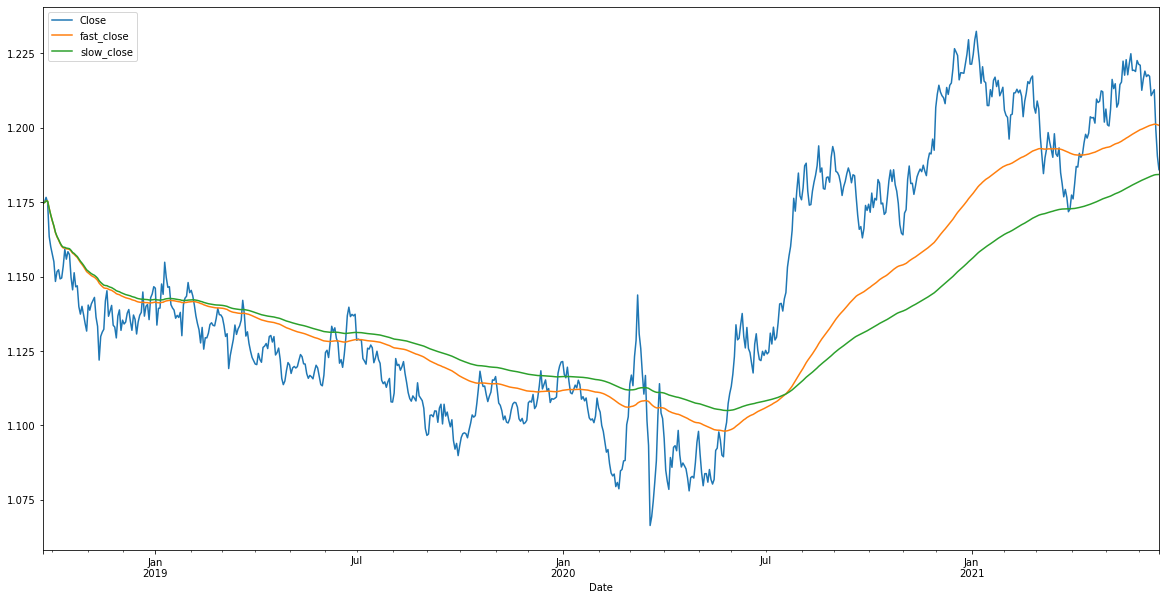

In [30]:
eur_signals[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [31]:
# Set short and long volatility windows
short_vol_window_eur = 1
long_vol_window_eur = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eur_signals['fast_vol'] = eur_signals['Daily Returns'].ewm(halflife=short_vol_window_eur).std()
eur_signals['slow_vol'] = eur_signals['Daily Returns'].ewm(halflife=long_vol_window_eur).std()

# Construct a crossover trading signal
eur_signals['vol_trend_long'] = np.where(eur_signals['fast_vol'] < eur_signals['slow_vol'], 1.0, 0.0)
eur_signals['vol_trend_short'] = np.where(eur_signals['fast_vol'] > eur_signals['slow_vol'], -1.0, 0.0) 
eur_signals['vol_trend_signal'] = eur_signals['vol_trend_long'] + eur_signals['vol_trend_short']

eur_signals

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,
2018-09-21,1.17474,NaN,1.174740,1.174740,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2018-09-24,1.17500,0.000221,1.174871,1.174870,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2018-09-25,1.17662,0.001379,1.175462,1.175458,1.0,0.0,1.0,0.000818,0.000818,0.0,-1.0,-1.0
2018-09-26,1.17490,-0.001462,1.175319,1.175317,1.0,0.0,1.0,0.001675,0.001455,0.0,-1.0,-1.0
2018-09-27,1.16346,-0.009737,1.172881,1.172912,0.0,-1.0,-1.0,0.006000,0.005171,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,1.21182,0.000842,1.201040,1.183944,1.0,0.0,1.0,0.003247,0.003455,1.0,0.0,1.0
2021-06-15,1.21280,0.000809,1.201202,1.184145,1.0,0.0,1.0,0.002536,0.003346,1.0,0.0,1.0
2021-06-16,1.19940,-0.011049,1.201177,1.184251,1.0,0.0,1.0,0.006958,0.004269,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

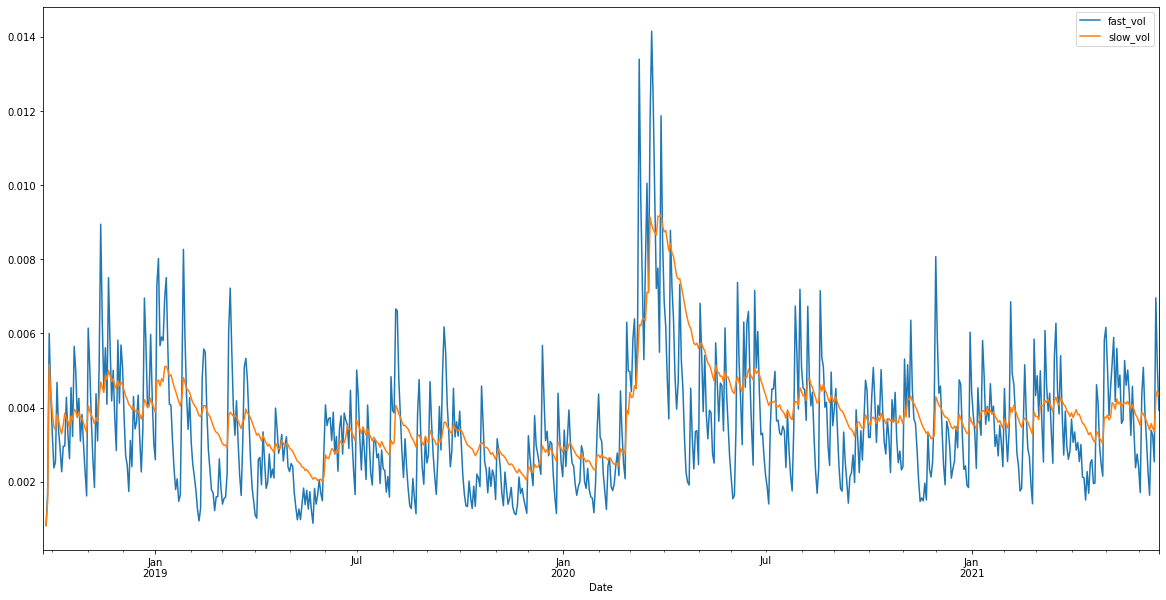

In [32]:
eur_signals[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [33]:
# Set bollinger band window
bollinger_window_eur = 20

# Calculate rolling mean and standard deviation
eur_signals['bollinger_mid_band'] = eur_signals['Close'].rolling(window=bollinger_window_eur).mean()
eur_signals['bollinger_std'] = eur_signals['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
eur_signals['bollinger_upper_band']  = eur_signals['bollinger_mid_band'] + (eur_signals['bollinger_std'] * 1)
eur_signals['bollinger_lower_band']  = eur_signals['bollinger_mid_band'] - (eur_signals['bollinger_std'] * 1)

# Calculate bollinger band trading signal
eur_signals['bollinger_long'] = np.where(eur_signals['Close'] < eur_signals['bollinger_lower_band'], 1.0, 0.0)
eur_signals['bollinger_short'] = np.where(eur_signals['Close'] > eur_signals['bollinger_upper_band'], -1.0, 0.0)
eur_signals['bollinger_signal'] = eur_signals['bollinger_long'] + eur_signals['bollinger_short']

eur_signals

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
2018-09-21,1.17474,NaN,1.174740,1.174740,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-24,1.17500,0.000221,1.174871,1.174870,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-25,1.17662,0.001379,1.175462,1.175458,1.0,0.0,1.0,0.000818,0.000818,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-26,1.17490,-0.001462,1.175319,1.175317,1.0,0.0,1.0,0.001675,0.001455,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-27,1.16346,-0.009737,1.172881,1.172912,0.0,-1.0,-1.0,0.006000,0.005171,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,1.21182,0.000842,1.201040,1.183944,1.0,0.0,1.0,0.003247,0.003455,1.0,0.0,1.0,1.218635,0.003738,1.222373,1.214897,1.0,0.0,1.0
2021-06-15,1.21280,0.000809,1.201202,1.184145,1.0,0.0,1.0,0.002536,0.003346,1.0,0.0,1.0,1.218155,0.003844,1.221999,1.214311,1.0,0.0,1.0
2021-06-16,1.19940,-0.011049,1.201177,1.184251,1.0,0.0,1.0,0.006958,0.004269,0.0,-1.0,-1.0,1.217242,0.005692,1.222933,1.211550,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

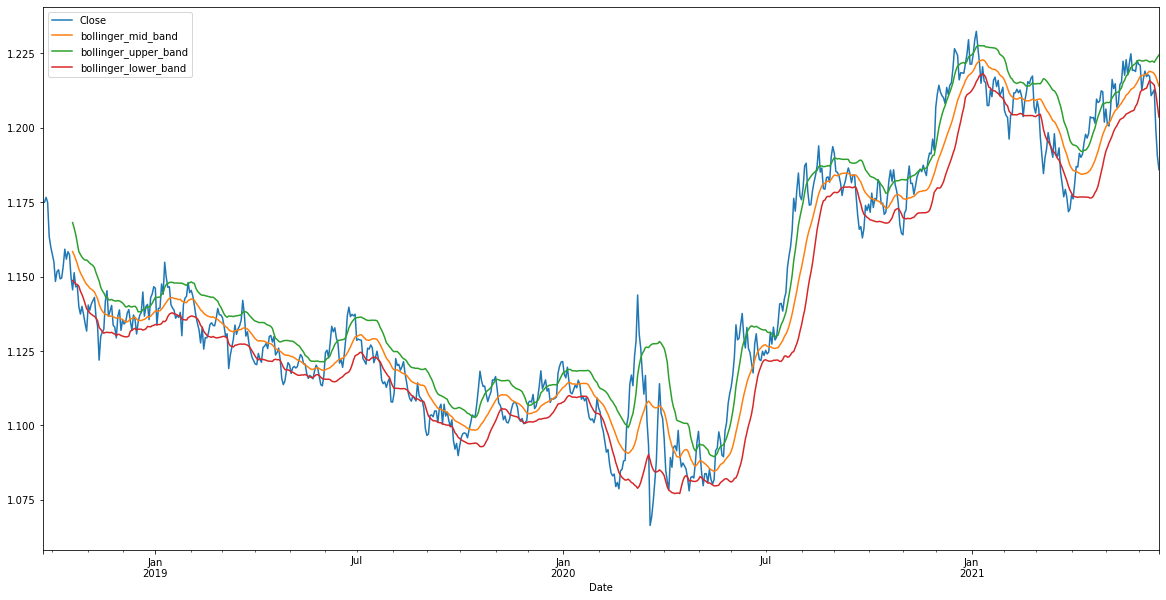

In [34]:
# Plot the Bollinger Bands for BTC/USD closing prices
eur_signals[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

# Random Forrest Training EUR

In [35]:
x_var_list_eur = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
eur_signals[x_var_list_eur].tail(10)

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-06-07,1.0,-1.0,0.0
2021-06-08,1.0,1.0,0.0
2021-06-09,1.0,1.0,0.0
2021-06-10,1.0,1.0,0.0
2021-06-11,1.0,1.0,1.0
2021-06-14,1.0,1.0,1.0
2021-06-15,1.0,1.0,1.0
2021-06-16,1.0,-1.0,1.0
2021-06-17,1.0,-1.0,1.0


In [36]:
eur_signals[x_var_list_eur] = eur_signals[x_var_list_eur].shift(1)
eur_signals[x_var_list_eur].tail(10)

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-06-07,1.0,-1.0,0.0
2021-06-08,1.0,-1.0,0.0
2021-06-09,1.0,1.0,0.0
2021-06-10,1.0,1.0,0.0
2021-06-11,1.0,1.0,0.0
2021-06-14,1.0,1.0,1.0
2021-06-15,1.0,1.0,1.0
2021-06-16,1.0,1.0,1.0
2021-06-17,1.0,-1.0,1.0


In [38]:
eur_signals.dropna(subset=x_var_list_eur, inplace=True)
eur_signals.dropna(subset=['Daily Returns'], inplace=True)
eur_signals = eur_signals.replace([np.inf, -np.inf], np.nan)
eur_signals.head()

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
2018-09-24,1.17500,0.000221,1.174871,1.174870,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-25,1.17662,0.001379,1.175462,1.175458,1.0,0.0,1.0,0.000818,0.000818,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-26,1.17490,-0.001462,1.175319,1.175317,1.0,0.0,1.0,0.001675,0.001455,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-27,1.16346,-0.009737,1.172881,1.172912,0.0,-1.0,1.0,0.006000,0.005171,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-28,1.16000,-0.002974,1.170659,1.170723,0.0,-1.0,-1.0,0.004365,0.004400,1.0,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [42]:
eur_signals['Positive Return'] = np.where(eur_signals['Daily Returns'] > 0, 1.0, 0.0)
eur_signals

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,
2018-09-24,1.17500,0.000221,1.174871,1.174870,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-09-25,1.17662,0.001379,1.175462,1.175458,1.0,0.0,1.0,0.000818,0.000818,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-09-26,1.17490,-0.001462,1.175319,1.175317,1.0,0.0,1.0,0.001675,0.001455,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-09-27,1.16346,-0.009737,1.172881,1.172912,0.0,-1.0,1.0,0.006000,0.005171,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-09-28,1.16000,-0.002974,1.170659,1.170723,0.0,-1.0,-1.0,0.004365,0.004400,1.0,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,1.21182,0.000842,1.201040,1.183944,1.0,0.0,1.0,0.003247,0.003455,1.0,0.0,1.0,1.218635,0.003738,1.222373,1.214897,1.0,0.0,1.0,1.0
2021-06-15,1.21280,0.000809,1.201202,1.184145,1.0,0.0,1.0,0.002536,0.003346,1.0,0.0,1.0,1.218155,0.003844,1.221999,1.214311,1.0,0.0,1.0,1.0
2021-06-16,1.19940,-0.011049,1.201177,1.184251,1.0,0.0,1.0,0.006958,0.004269,0.0,-1.0,1.0,1.217242,0.005692,1.222933,1.211550,1.0,0.0,1.0,0.0


In [44]:
training_start = eur_signals.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-08-24'

# Construct testing start and end dates
testing_start =  '2020-08-25'
testing_end = eur_signals.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-09-24
Training End: 2020-08-24
Testing Start: 2020-08-25
Testing End: 2021-06-18


In [45]:
# Construct the X_train and y_train datasets
X_train_eur = eur_signals[x_var_list_eur][training_start:training_end]
y_train_eur = eur_signals['Positive Return'][training_start:training_end]

X_train_eur.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-08-18,1.0,1.0,-1.0
2020-08-19,1.0,1.0,-1.0
2020-08-20,1.0,-1.0,0.0
2020-08-21,1.0,-1.0,0.0
2020-08-24,1.0,-1.0,0.0


In [48]:
X_test_eur = eur_signals[x_var_list_eur][testing_start:testing_end]
y_test_eur = eur_signals['Positive Return'][testing_start:testing_end]

X_test_eur.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-06-14,1.0,1.0,1.0
2021-06-15,1.0,1.0,1.0
2021-06-16,1.0,1.0,1.0
2021-06-17,1.0,-1.0,1.0
2021-06-18,1.0,-1.0,1.0


In [49]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model_eur = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model_eur.fit(X_train_eur, y_train_eur)

# Make a prediction of "y" values from the X_test dataset
predictions_eur = model_eur.predict(X_test_eur)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results_eur = y_test_eur.to_frame()
Results_eur["Predicted Value"] = predictions_eur
Results_eur

,Positive Return,Predicted Value
Date,,
2020-08-25,1.0,1.0
2020-08-26,1.0,1.0
2020-08-27,0.0,1.0
2020-08-28,1.0,1.0
2020-08-31,1.0,1.0
...,...,...
2021-06-14,1.0,1.0
2021-06-15,1.0,1.0
2021-06-16,0.0,1.0


In [51]:
acc_score_eur = accuracy_score(y_test_eur, predictions_eur)

acc_score_eur

0.4953271028037383

In [61]:
eur_daily_returns = eur_signals["Daily Returns"]
results_eur_returns = pd.concat([Results_eur, eur_daily_returns], axis=1)
results_eur_returns.dropna(inplace=True)
results_eur_returns

,Positive Return,Predicted Value,Daily Returns
Date,,,
2020-08-25,1.0,1.0,0.003315
2020-08-26,1.0,1.0,0.000194
2020-08-27,0.0,1.0,-0.001521
2020-08-28,1.0,1.0,0.007091
2020-08-31,1.0,1.0,0.003042
...,...,...,...
2021-06-14,1.0,1.0,0.000842
2021-06-15,1.0,1.0,0.000809
2021-06-16,0.0,1.0,-0.011049


<AxesSubplot:xlabel='Date'>

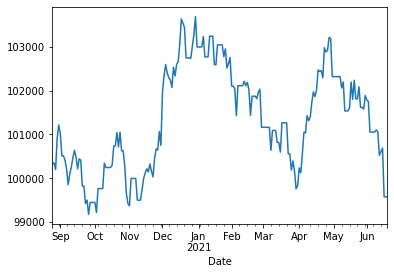

In [63]:
# Set initial capital allocation
initial_capital_eur = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital_eur = initial_capital_eur * (1 + (results_eur_returns['Daily Returns'] * results_eur_returns['Predicted Value'])).cumprod()
cumulative_return_capital_eur.plot()

# Bitcoin Signals

In [79]:
#btc = app.get_daily_adjusted('BTCUSD')

In [80]:
url_btc= 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=BTCUSD&outputsize=full&apikey='+'8YH9QLMWXNG5DNG0'
r_btc = requests.get(url_btc)
btc_usd = r_btc.json()
#btc_usd['Time Series (Daily)']

In [81]:
'''
date= btc[0].keys()
close = []
for item in date:
    close.append(btc[0][item]['4. close'])
    '''

"\ndate= btc[0].keys()\nclose = []\nfor item in date:\n    close.append(btc[0][item]['4. close'])\n    "

In [82]:
date= btc_usd['Time Series (Daily)'].keys()
close = []
for item in date:
    close.append(btc_usd['Time Series (Daily)'][item]['4. close'])

In [83]:
btc = pd.DataFrame(close, columns = ['Close'])
btc['Date']= date
btc.set_index(['Date'], inplace=True)
btc.sort_values(by='Date', ascending = True, inplace=True)
btc.reset_index(inplace = True)
btc

,Date,Close
0,2018-09-23,6708.0
1,2018-09-24,6581.39
2,2018-09-25,6447.54
3,2018-09-26,6465.12
4,2018-09-27,6689.13
...,...,...
995,2021-06-14,40516.29
996,2021-06-15,40144.04
997,2021-06-16,38349.01
998,2021-06-17,38092.97


In [84]:
signals_btc = btc.loc[:, ["Date", "Close"]].copy()

# Set the short window and long windows
short_window = 30
long_window = 60

# Set the `date` column as the index
signals_btc = signals_btc.set_index("Date", drop=True)

# Generate the short and long moving averages (50 and 100 days, respectively)
signals_btc["SMA50"] = signals_btc["Close"].rolling(window=short_window).mean()
signals_btc["SMA100"] = signals_btc["Close"].rolling(window=long_window).mean()
signals_btc["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
signals_btc["Signal"][short_window:] = np.where(
    signals_btc["SMA50"][short_window:] > signals_btc["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_btc["Entry/Exit"] = signals_btc["Signal"].diff()


<ipython-input-84-262cc16340e7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_btc["Signal"][short_window:] = np.where(


In [85]:
signals_btc.head()

,Close,SMA50,SMA100,Signal,Entry/Exit
Date,,,,,
2018-09-23,6708.0,NaN,NaN,0.0,NaN
2018-09-24,6581.39,NaN,NaN,0.0,0.0
2018-09-25,6447.54,NaN,NaN,0.0,0.0
2018-09-26,6465.12,NaN,NaN,0.0,0.0
2018-09-27,6689.13,NaN,NaN,0.0,0.0


In [86]:

signals_btc["Close"] = pd.to_numeric(signals_btc["Close"], downcast="float")

In [87]:
signals_btc.head()

,Close,SMA50,SMA100,Signal,Entry/Exit
Date,,,,,
2018-09-23,6708.000000,NaN,NaN,0.0,NaN
2018-09-24,6581.390137,NaN,NaN,0.0,0.0
2018-09-25,6447.540039,NaN,NaN,0.0,0.0
2018-09-26,6465.120117,NaN,NaN,0.0,0.0
2018-09-27,6689.129883,NaN,NaN,0.0,0.0


In [88]:
exit = signals_btc[signals_btc['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

entry = signals_btc[signals_btc['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

security_close = signals_btc[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

moving_avgs = signals_btc[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Creating Various Trading Signals for Bitcoin

In [90]:
btc.set_index(pd.to_datetime(btc['Date'], infer_datetime_format=True), inplace=True)
btc.drop(columns=['Date'], inplace=True)
btc['Close'] = btc['Close'].astype(float)
btc

,Close
Date,
2018-09-23,6708.00
2018-09-24,6581.39
2018-09-25,6447.54
2018-09-26,6465.12
2018-09-27,6689.13
...,...
2021-06-14,40516.29
2021-06-15,40144.04
2021-06-16,38349.01


In [91]:
btc['Daily Returns'] = btc['Close'].dropna().pct_change()
btc

,Close,Daily Returns
Date,,
2018-09-23,6708.00,NaN
2018-09-24,6581.39,-0.018874
2018-09-25,6447.54,-0.020338
2018-09-26,6465.12,0.002727
2018-09-27,6689.13,0.034649
...,...,...
2021-06-14,40516.29,0.038332
2021-06-15,40144.04,-0.009188
2021-06-16,38349.01,-0.044715


In [92]:
# Set short and long windows
short_window_btc = 1
long_window_btc = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
btc['fast_close'] = btc['Close'].ewm(halflife=short_window_btc).mean()
btc['slow_close'] = btc['Close'].ewm(halflife=long_window_btc).mean()

# Construct a crossover trading signal
btc['crossover_long'] = np.where(btc['fast_close'] > btc['slow_close'], 1.0, 0.0)
btc['crossover_short'] = np.where(btc['fast_close'] < btc['slow_close'], -1.0, 0.0)
btc['crossover_signal'] = btc['crossover_long'] + btc['crossover_short']

btc.head()

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
2018-09-23,6708.00,NaN,6708.000000,6708.000000,0.0,0.0,0.0
2018-09-24,6581.39,-0.018874,6623.593333,6642.501894,0.0,-1.0,-1.0
2018-09-25,6447.54,-0.020338,6522.991429,6572.961647,0.0,-1.0,-1.0
2018-09-26,6465.12,0.002727,6492.126667,6543.136829,0.0,-1.0,-1.0
2018-09-27,6689.13,0.034649,6593.805806,6576.516659,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

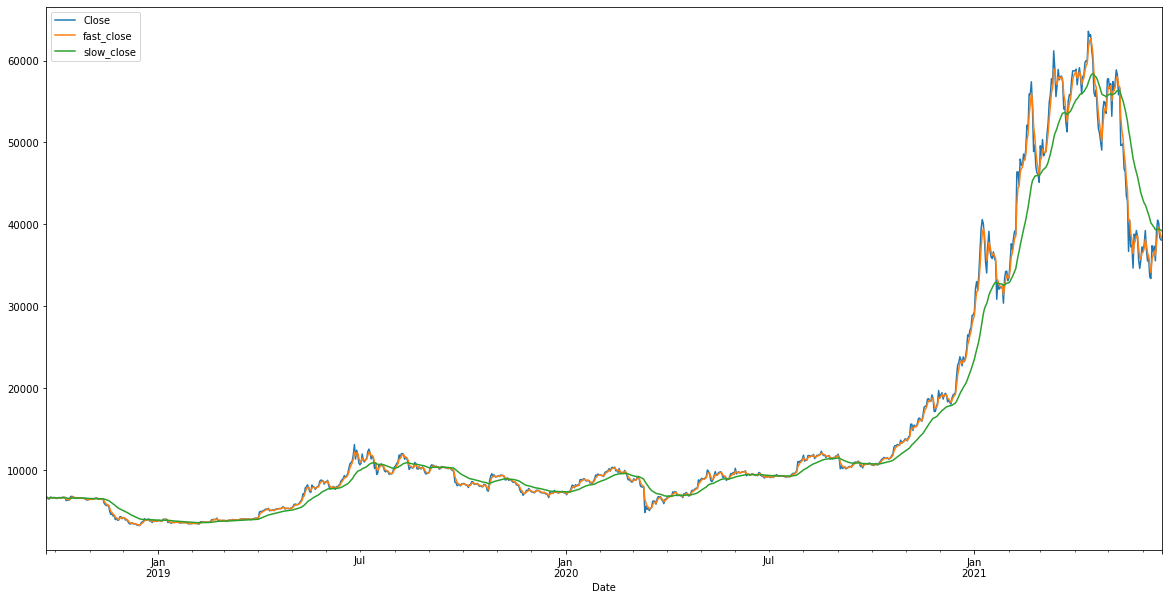

In [93]:
btc[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [94]:
# Set short and long volatility windows
short_vol_window_btc = 1
long_vol_window_btc = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
btc['fast_vol'] = btc['Daily Returns'].ewm(halflife=short_vol_window_btc).std()
btc['slow_vol'] = btc['Daily Returns'].ewm(halflife=long_vol_window_btc).std()

# Construct a crossover trading signal
btc['vol_trend_long'] = np.where(btc['fast_vol'] < btc['slow_vol'], 1.0, 0.0)
btc['vol_trend_short'] = np.where(btc['fast_vol'] > btc['slow_vol'], -1.0, 0.0) 
btc['vol_trend_signal'] = btc['vol_trend_long'] + btc['vol_trend_short']

btc

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,
2018-09-23,6708.00,NaN,6708.000000,6708.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2018-09-24,6581.39,-0.018874,6623.593333,6642.501894,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2018-09-25,6447.54,-0.020338,6522.991429,6572.961647,0.0,-1.0,-1.0,0.001035,0.001035,0.0,0.0,0.0
2018-09-26,6465.12,0.002727,6492.126667,6543.136829,0.0,-1.0,-1.0,0.014792,0.013147,0.0,-1.0,-1.0
2018-09-27,6689.13,0.034649,6593.805806,6576.516659,1.0,0.0,1.0,0.028034,0.026160,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,40516.29,0.038332,39053.171377,39394.714458,0.0,-1.0,-1.0,0.056246,0.057912,1.0,0.0,1.0
2021-06-15,40144.04,-0.009188,39598.605688,39444.894548,1.0,0.0,1.0,0.049780,0.056045,1.0,0.0,1.0
2021-06-16,38349.01,-0.044715,38973.807844,39371.506438,0.0,-1.0,-1.0,0.050870,0.055508,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

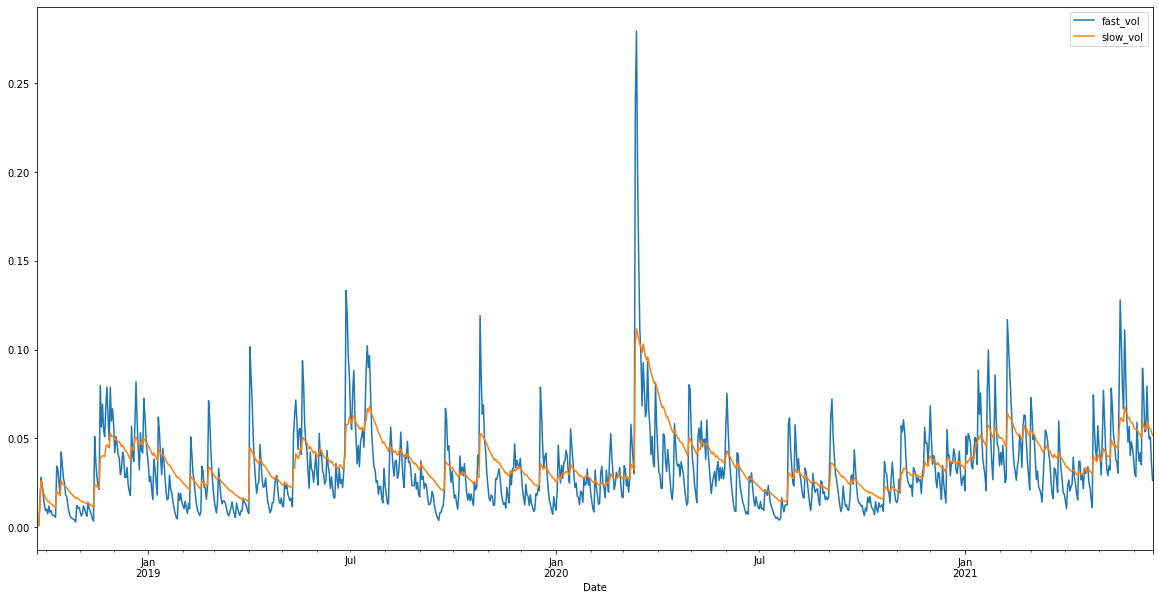

In [95]:
btc[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [96]:
# Set bollinger band window
bollinger_window_btc = 20

# Calculate rolling mean and standard deviation
btc['bollinger_mid_band'] = btc['Close'].rolling(window=bollinger_window_btc).mean()
btc['bollinger_std'] = btc['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
btc['bollinger_upper_band']  = btc['bollinger_mid_band'] + (btc['bollinger_std'] * 1)
btc['bollinger_lower_band']  = btc['bollinger_mid_band'] - (btc['bollinger_std'] * 1)

# Calculate bollinger band trading signal
btc['bollinger_long'] = np.where(btc['Close'] < btc['bollinger_lower_band'], 1.0, 0.0)
btc['bollinger_short'] = np.where(btc['Close'] > btc['bollinger_upper_band'], -1.0, 0.0)
btc['bollinger_signal'] = btc['bollinger_long'] + btc['bollinger_short']

btc

,Close,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
2018-09-23,6708.00,NaN,6708.000000,6708.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-24,6581.39,-0.018874,6623.593333,6642.501894,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-25,6447.54,-0.020338,6522.991429,6572.961647,0.0,-1.0,-1.0,0.001035,0.001035,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-26,6465.12,0.002727,6492.126667,6543.136829,0.0,-1.0,-1.0,0.014792,0.013147,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-27,6689.13,0.034649,6593.805806,6576.516659,1.0,0.0,1.0,0.028034,0.026160,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,40516.29,0.038332,39053.171377,39394.714458,0.0,-1.0,-1.0,0.056246,0.057912,1.0,0.0,1.0,36799.7500,1906.498717,38706.248717,34893.251283,0.0,-1.0,-1.0
2021-06-15,40144.04,-0.009188,39598.605688,39444.894548,1.0,0.0,1.0,0.049780,0.056045,1.0,0.0,1.0,36844.8565,1976.699109,38821.555609,34868.157391,0.0,-1.0,-1.0
2021-06-16,38349.01,-0.044715,38973.807844,39371.506438,0.0,-1.0,-1.0,0.050870,0.055508,1.0,0.0,1.0,36835.8080,1968.978456,38804.786456,34866.829544,0.0,0.0,0.0


<AxesSubplot:xlabel='Date'>

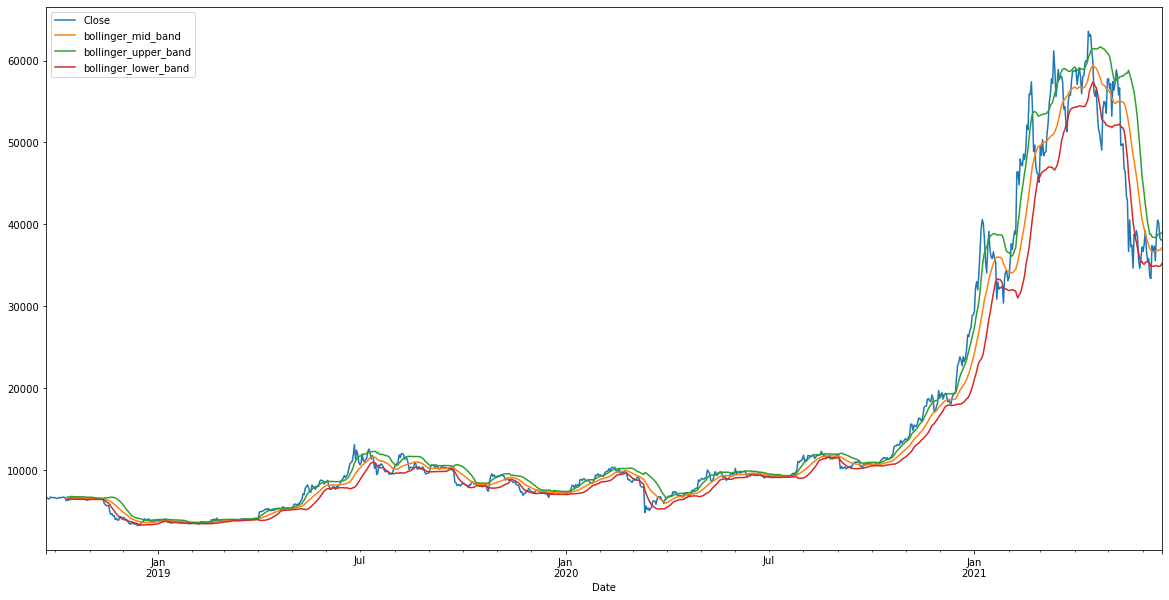

In [97]:
btc[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

# Gold Trading Signal

In [118]:
gold= pd.read_csv("Gold Futures Historical Data (3).csv")
gold['Date'] = pd.to_datetime(gold.Date)
gold.set_index(['Date'], inplace=True)
gold.sort_values(by='Date', ascending = True, inplace=True)
gold.reset_index(inplace = True)
gold

,Date,Price,Open,High,Low,Vol.,Change %
0,2018-09-21,1274.30,1274.3,1274.30,1274.3,0.04K,-0.79%
1,2018-09-24,1277.40,1277.4,1277.40,1277.4,0.01K,0.24%
2,2018-09-25,1278.20,1278.2,1278.20,1278.2,0.02K,0.06%
3,2018-09-26,1271.80,1271.8,1271.80,1271.8,0.00K,-0.5%
4,2018-09-27,1259.80,1260.0,1260.00,1260.0,0.00K,-0.94%
...,...,...,...,...,...,...,...
717,2021-06-09,1895.50,1894.4,1901.70,1889.3,147.33K,0.06%
718,2021-06-10,1896.40,1891.4,1903.00,1871.8,250.55K,0.05%
719,2021-06-11,1879.60,1901.9,1906.20,1876.1,220.46K,-0.89%
720,2021-06-14,1865.90,1879.6,1879.70,1845.7,242.30K,-0.73%


In [119]:
signals_gold = gold.loc[:, ["Date", "Price"]].copy()

# Set the short window and long windows
short_window = 12
long_window = 50

# Set the `date` column as the index
signals_gold = signals_gold.set_index("Date", drop=True)

# Generate the short and long moving averages (50 and 100 days, respectively)
signals_gold["SMA10"] = signals_gold["Price"].rolling(window=short_window).mean()
signals_gold["SMA20"] = signals_gold["Price"].rolling(window=long_window).mean()
signals_gold["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
signals_gold["Signal"][short_window:] = np.where(
    signals_gold["SMA10"][short_window:] > signals_gold["SMA20"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_gold["Entry/Exit"] = signals_gold["Signal"].diff()


In [120]:
signals_gold

,Price,SMA10,SMA20,Signal,Entry/Exit
Date,,,,,
2018-09-21,1274.30,NaN,NaN,0.0,NaN
2018-09-24,1277.40,NaN,NaN,0.0,0.0
2018-09-25,1278.20,NaN,NaN,0.0,0.0
2018-09-26,1271.80,NaN,NaN,0.0,0.0
2018-09-27,1259.80,NaN,NaN,0.0,0.0
...,...,...,...,...,...
2021-06-09,1895.50,1899.533333,1823.366,1.0,0.0
2021-06-10,1896.40,1898.916667,1826.688,1.0,0.0
2021-06-11,1879.60,1897.341667,1829.666,1.0,0.0


In [121]:
exit = signals_gold[signals_gold['Entry/Exit'] == -1.0]['Price'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

entry = signals_gold[signals_gold['Entry/Exit'] == 1.0]['Price'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

security_close = signals_gold[['Price']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

moving_avgs = signals_gold[['SMA10', 'SMA20']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Price)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Price.I  :Scatter   [Date]   (Price)
   .Scatter.Price.II :Scatter   [Date]   (Price)

# Creating Various Trade Signals for Gold

In [122]:
gold.set_index(pd.to_datetime(gold['Date'], infer_datetime_format=True), inplace=True)
gold.drop(columns=['Date'], inplace=True)
gold['Price'] = gold['Price'].astype(float)
gold

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-09-21,1274.30,1274.3,1274.30,1274.3,0.04K,-0.79%
2018-09-24,1277.40,1277.4,1277.40,1277.4,0.01K,0.24%
2018-09-25,1278.20,1278.2,1278.20,1278.2,0.02K,0.06%
2018-09-26,1271.80,1271.8,1271.80,1271.8,0.00K,-0.5%
2018-09-27,1259.80,1260.0,1260.00,1260.0,0.00K,-0.94%
...,...,...,...,...,...,...
2021-06-09,1895.50,1894.4,1901.70,1889.3,147.33K,0.06%
2021-06-10,1896.40,1891.4,1903.00,1871.8,250.55K,0.05%
2021-06-11,1879.60,1901.9,1906.20,1876.1,220.46K,-0.89%


In [123]:
gold['Daily Returns'] = gold['Price'].dropna().pct_change()
gold

,Price,Open,High,Low,Vol.,Change %,Daily Returns
Date,,,,,,,
2018-09-21,1274.30,1274.3,1274.30,1274.3,0.04K,-0.79%,NaN
2018-09-24,1277.40,1277.4,1277.40,1277.4,0.01K,0.24%,0.002433
2018-09-25,1278.20,1278.2,1278.20,1278.2,0.02K,0.06%,0.000626
2018-09-26,1271.80,1271.8,1271.80,1271.8,0.00K,-0.5%,-0.005007
2018-09-27,1259.80,1260.0,1260.00,1260.0,0.00K,-0.94%,-0.009435
...,...,...,...,...,...,...,...
2021-06-09,1895.50,1894.4,1901.70,1889.3,147.33K,0.06%,0.000581
2021-06-10,1896.40,1891.4,1903.00,1871.8,250.55K,0.05%,0.000475
2021-06-11,1879.60,1901.9,1906.20,1876.1,220.46K,-0.89%,-0.008859


In [125]:
# Set short and long windows
short_window_gold = 1
long_window_gold = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
gold['fast_close'] = gold['Price'].ewm(halflife=short_window_gold).mean()
gold['slow_close'] = gold['Price'].ewm(halflife=long_window_gold).mean()

# Construct a crossover trading signal
gold['crossover_long'] = np.where(gold['fast_close'] > gold['slow_close'], 1.0, 0.0)
gold['crossover_short'] = np.where(gold['fast_close'] < gold['slow_close'], -1.0, 0.0)
gold['crossover_signal'] = gold['crossover_long'] + gold['crossover_short']

gold.head()

,Price,Open,High,Low,Vol.,Change %,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,,
2018-09-21,1274.3,1274.3,1274.3,1274.3,0.04K,-0.79%,NaN,1274.300000,1274.300000,0.0,0.0,0.0
2018-09-24,1277.4,1277.4,1277.4,1277.4,0.01K,0.24%,0.002433,1276.366667,1275.903697,1.0,0.0,1.0
2018-09-25,1278.2,1278.2,1278.2,1278.2,0.02K,0.06%,0.000626,1277.414286,1276.722757,1.0,0.0,1.0
2018-09-26,1271.8,1271.8,1271.8,1271.8,0.00K,-0.5%,-0.005007,1274.420000,1275.361313,0.0,-1.0,-1.0
2018-09-27,1259.8,1260.0,1260.0,1260.0,0.00K,-0.94%,-0.009435,1266.874194,1271.803380,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

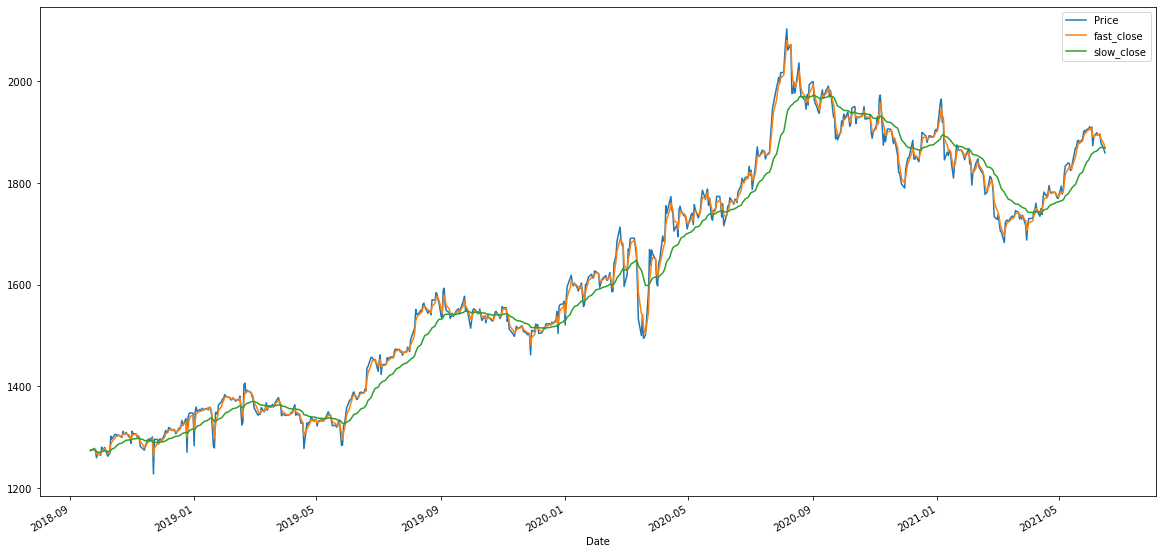

In [127]:
gold[['Price', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [129]:
# Set short and long volatility windows
short_vol_window_gold = 1
long_vol_window_gold = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
gold['fast_vol'] = gold['Daily Returns'].ewm(halflife=short_vol_window_gold).std()
gold['slow_vol'] = gold['Daily Returns'].ewm(halflife=long_vol_window_gold).std()

# Construct a crossover trading signal
gold['vol_trend_long'] = np.where(gold['fast_vol'] < gold['slow_vol'], 1.0, 0.0)
gold['vol_trend_short'] = np.where(gold['fast_vol'] > gold['slow_vol'], -1.0, 0.0) 
gold['vol_trend_signal'] = gold['vol_trend_long'] + gold['vol_trend_short']

gold

,Price,Open,High,Low,Vol.,Change %,Daily Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,,
2018-09-21,1274.30,1274.3,1274.30,1274.3,0.04K,-0.79%,NaN,1274.300000,1274.300000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2018-09-24,1277.40,1277.4,1277.40,1277.4,0.01K,0.24%,0.002433,1276.366667,1275.903697,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2018-09-25,1278.20,1278.2,1278.20,1278.2,0.02K,0.06%,0.000626,1277.414286,1276.722757,1.0,0.0,1.0,0.001277,0.001277,0.0,0.0,0.0
2018-09-26,1271.80,1271.8,1271.80,1271.8,0.00K,-0.5%,-0.005007,1274.420000,1275.361313,0.0,-1.0,-1.0,0.004148,0.003921,0.0,-1.0,-1.0
2018-09-27,1259.80,1260.0,1260.00,1260.0,0.00K,-0.94%,-0.009435,1266.874194,1271.803380,0.0,-1.0,-1.0,0.005248,0.005452,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-09,1895.50,1894.4,1901.70,1889.3,147.33K,0.06%,0.000581,1895.119419,1867.400862,1.0,0.0,1.0,0.005615,0.007240,1.0,0.0,1.0
2021-06-10,1896.40,1891.4,1903.00,1871.8,250.55K,0.05%,0.000475,1895.759710,1869.342847,1.0,0.0,1.0,0.003973,0.006996,1.0,0.0,1.0
2021-06-11,1879.60,1901.9,1906.20,1876.1,220.46K,-0.89%,-0.008859,1887.679855,1870.029738,1.0,0.0,1.0,0.006297,0.007215,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

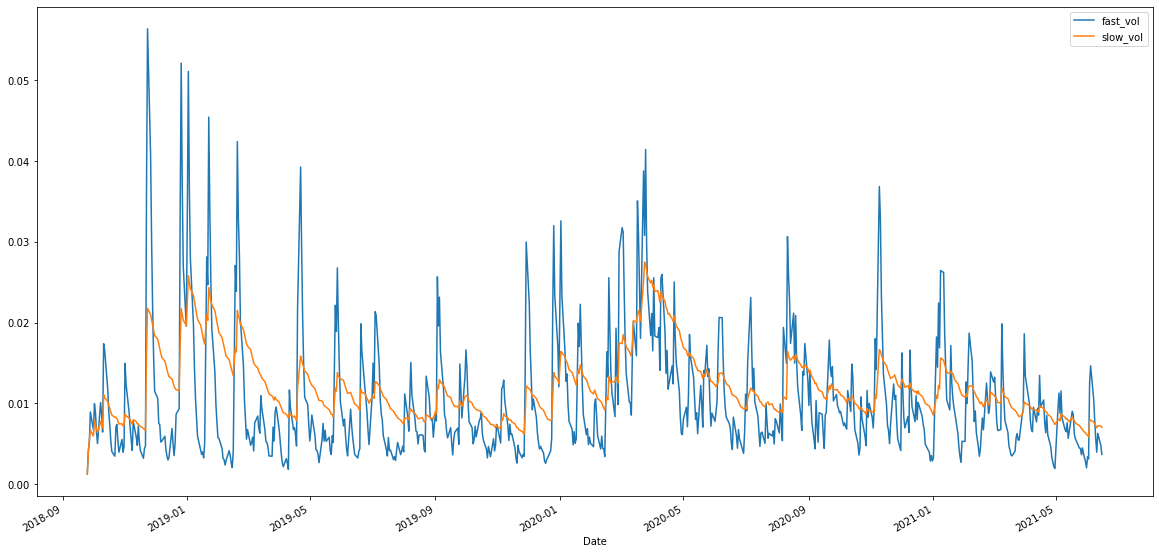

In [130]:
gold[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [132]:
# Set bollinger band window
bollinger_window_gold = 20

# Calculate rolling mean and standard deviation
gold['bollinger_mid_band'] = gold['Price'].rolling(window=bollinger_window_gold).mean()
gold['bollinger_std'] = gold['Price'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
gold['bollinger_upper_band']  = gold['bollinger_mid_band'] + (gold['bollinger_std'] * 1)
gold['bollinger_lower_band']  = gold['bollinger_mid_band'] - (gold['bollinger_std'] * 1)

# Calculate bollinger band trading signal
gold['bollinger_long'] = np.where(gold['Price'] < gold['bollinger_lower_band'], 1.0, 0.0)
gold['bollinger_short'] = np.where(gold['Price'] > gold['bollinger_upper_band'], -1.0, 0.0)
gold['bollinger_signal'] = gold['bollinger_long'] + gold['bollinger_short']

gold

,Price,Open,High,Low,Vol.,Change %,Daily Returns,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-21,1274.30,1274.3,1274.30,1274.3,0.04K,-0.79%,NaN,1274.300000,1274.300000,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-24,1277.40,1277.4,1277.40,1277.4,0.01K,0.24%,0.002433,1276.366667,1275.903697,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-25,1278.20,1278.2,1278.20,1278.2,0.02K,0.06%,0.000626,1277.414286,1276.722757,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-26,1271.80,1271.8,1271.80,1271.8,0.00K,-0.5%,-0.005007,1274.420000,1275.361313,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-09-27,1259.80,1260.0,1260.00,1260.0,0.00K,-0.94%,-0.009435,1266.874194,1271.803380,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-09,1895.50,1894.4,1901.70,1889.3,147.33K,0.06%,0.000581,1895.119419,1867.400862,1.0,...,1.0,0.0,1.0,1890.3750,17.606955,1907.981955,1872.768045,0.0,0.0,0.0
2021-06-10,1896.40,1891.4,1903.00,1871.8,250.55K,0.05%,0.000475,1895.759710,1869.342847,1.0,...,1.0,0.0,1.0,1893.1950,13.037808,1906.232808,1880.157192,0.0,0.0,0.0
2021-06-11,1879.60,1901.9,1906.20,1876.1,220.46K,-0.89%,-0.008859,1887.679855,1870.029738,1.0,...,1.0,0.0,1.0,1893.6950,12.253473,1905.948473,1881.441527,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

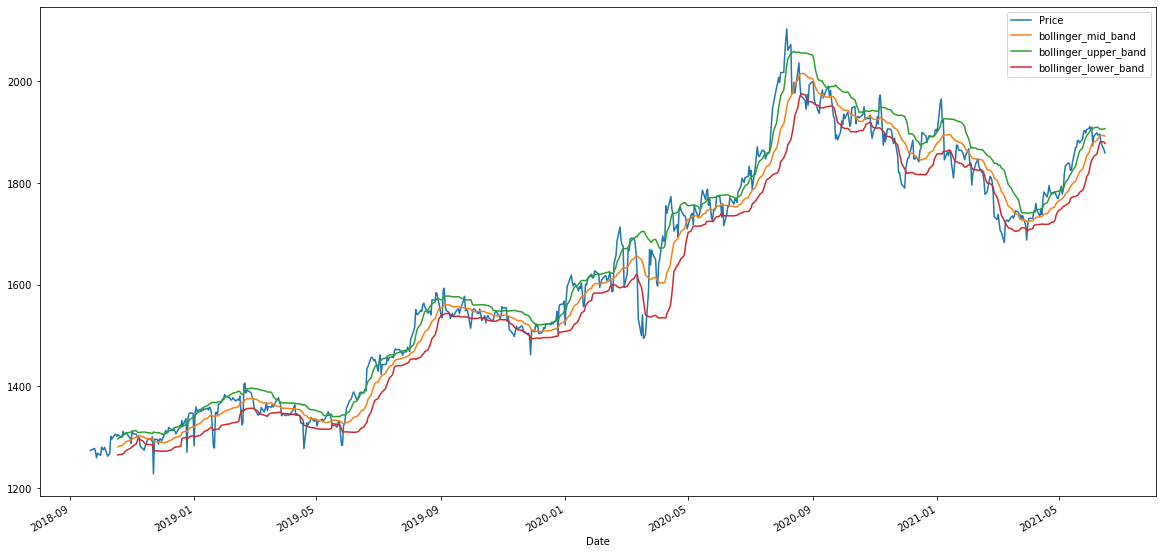

In [134]:
gold[['Price','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))